## Local field potential

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))

In [2]:
from utils import download_data
import lfp_functions as lf

In [3]:
download_data('https://surfdrive.surf.nl/files/index.php/s/7BosHgemAseANIc')

### <font color='indianred'> Introduction </font>

The **Local field potential** is the name that neuroscientists use to refer to the extracellular electric potential, ie, the potential in the space around neurons.

The use of LFP signals to investigate neural activity is common in systems neuroscience due to the relative ease of recording (a single electrode is sufficient to extract the signal) and the rich variaty of oscillatory phenomena it allows to probe.

The LFP results from the activity of the **local** neural population, in contrast with electrocorticography and electroencefalography, whose signal is the result of the activity of large cortical area, but it is not directly related to spiking activity: **the main contribution to LFP comes from the postsynaptic membrane potentials**.

In this lessoan we will look at a series of preprocessing and analysis methods used in the analysis of LFP. They all rely on the fact that **LFP is continuous signal** (unlike spiking activity) usually **sampled with very high time resolution**. This makes it tractable with a large family of signal processing tools.

### <font color='indianred'> Fourier analysis and power spectrum </font>

Continuous signals can often be decomposed as a superposition of elementary building blocks. For a signal that is sampled for a long time, a useful description is obtained by decomposing it as a sum of sine and cosine waves with different frequencies. For a periodic signal of period $T$, this is called Fourier decomposition and it is given by: $$ x(t) = \sum_{n=-\infty}^{+\infty}c_n\ e^{i\frac{2\pi}{T}nt}$$

The complex exponentials are oscillators with different frequencies and the Fourier coefficients $c_n$ represent the weight/contribution of each oscillator to the signal. The weights $c_n$ can be computed as $$c_n = \frac{1}{T}\int_T x(t)e^{i\frac{2\pi}{T}nt}dt$$

<font color='darkgreen'> By taking the square modulus of the coefficients $c_n$, we obtain the **power spectrum** of the signal which we can use to measures the contributions of different frequencies</font> 

#### <font color='indianred'> Nyquist frequency </font>

The sampling rate at which a signal is acquired sets a bound to the highest frequency that we can investigate with Fourier analysis. Intuitivelt, we do not have any information about variations to the signal that are faster (higher frequency) than the sampling interval.

The maximum frequency that we can resolve is called the **Nyquist frequency** and is given by $$f_{max} = \frac{1}{2\Delta t} = \frac{1}{2}f_{sampling}$$ where $\Delta t$ is the time interval between samples.

#### <font color='indianred'> Detrending and de-averaging </font>

Fourier analysis assumes a **stationary signal**, ie, a signal whose properties do not change over time. This is often not the case in data recorded from the brain. For instance, the average of the signal can be different at the beginning and ending of the recording.

To avoid picking up this difference as a low-frequency component, the signal is usually **detrended**: the variation of the mean from begiining to end is estimated (eg.: through a linear fit) and subtracted at each time from the original signal $$\tilde{x}(t) = x(t) - (at+b)$$ 

*It has been shown that this isn't an innocent move though, that is, detrending may introduce its  own noise/trend to the data.*

Also, usually the time average of the signal is subtracted to the signal itself. A **non-zero average (DC component) corresponds to a big zero-frequency component** that can overshadow the rest of the power spectrum and it is usually of no interest in the context of frequency analysis $$\tilde{x}(t) = x(t) - \langle x(t)\rangle_T$$

### <font color='indianred'> Example: Theta rythm in moving rodents </font>

The theta rythm is a well known oscillatory pattern with a frequency of around 8Hz that can be measured in the hippocampus of rodents during wake activity and is particularly prominent during locomotion.

We will use Fourier analysis (namely, FFT) to look at how the theta rythom shows up in data recorded from a mouse moving around.

In [4]:
with open('data/moving_lfp.pickle','rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


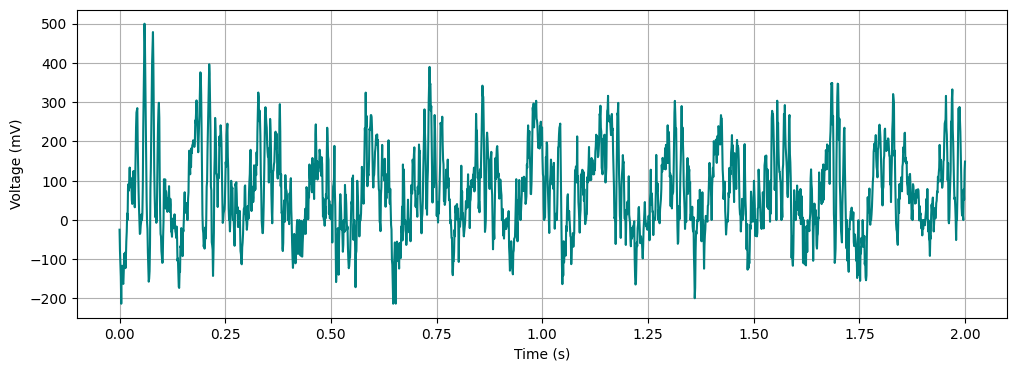

We can easily detect a prominent oscillation of around 8Hz. Can we see it in the power spectrum?


In [5]:
plt.figure(figsize=(12,4))
plt.plot(np.linspace(0,2,2000), lfp[:2000], color='teal')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.grid()
plt.show()
print('We can easily detect a prominent oscillation of around 8Hz. Can we see it in the power spectrum?')

Text(0, 0.5, 'Power')

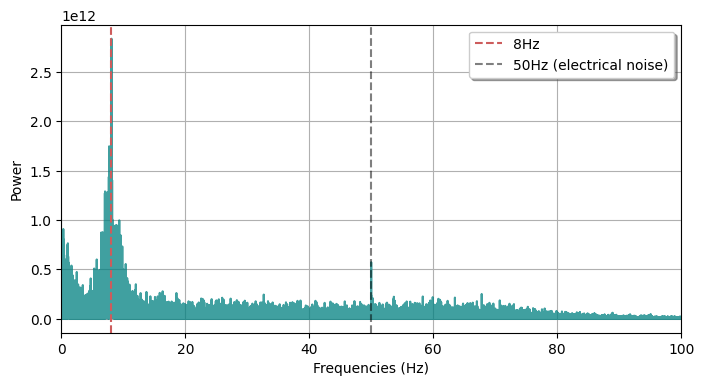

In [6]:
from scipy.fft import fft, fftfreq
n_samples = len(lfp)
sample_dt = 1 / sampling_rate

# Subtract the mean to get rid of the DC component
centered_lfp = lfp - np.mean(lfp)
transformed_signal = fft(centered_lfp)

frequencies = fftfreq(n_samples, sample_dt)

# Truncating
transformed_signal = transformed_signal[: n_samples//2]
frequencies = frequencies[: n_samples//2]

# Power spectrum
power_spectrum = abs(transformed_signal)**2

plt.figure(figsize=(8,4))
plt.plot(frequencies, power_spectrum,color='teal', alpha=0.75)
plt.xlim([0,100])
plt.axvline(x = 8, color='indianred', linestyle='--', label = '8Hz')
plt.axvline(x = 50, color='k', linestyle='--', alpha = 0.5, label = '50Hz (electrical noise)')
plt.grid()
plt.legend(shadow=True)
plt.xlabel('Frequencies (Hz)')
plt.ylabel('Power')

We can see a clear peak at 8 Hz corresponding to the well studied theta frequency band. In rodent, large activity in the theta band is known to be related to active bahaviour and locomotion in particular. 

<font color='darkgreen'> Computing the frequency power spectrum over the whole session yields information about the frequency content of the overall signal **but erases all temporal features**.</font> To see more detail about what is happening at any given time, we have to move to **time-frequency analysis** methods. Hence, we'll look at a few useful concepts and techniques in signal processing

## <font color='indianred'> FILTERING </font>

A filter is a device that removes an unwanted component of a signal. We will look at frequency filters that get rid of some of the frequencies in the LFP time series. 

A **low-pass filter** is a filter that gets ride of all the frequencies *above* a certain threshold frequency, whereas a **high-pass filter** gets ride of all frequencies *bellow* a certain threshold. A combination of the two corresponds to a **band-pass filter**.

In our case, we'll want to filter out very low frequency components (as we did with de-averaging, we can interpret it as filtering the 0 frequency component) and also very high frequencies that act as noise for the scale we are interested in.

We'll use the scipy implementation of a Butterworth filter, a filter that can be expressed as a compled polynomial of a chosen order and designed to have a response that is as flat as possible in the pass band (range of frequencies that "survives" a band-pass filter) to avoid distorsion of the filtered signal.

We will use the `scipy.signal.sosfilt` function that applies the 'cascade second order section method', anumerically stable implementation of the standard convolution procedure.


Text(0, 0.5, 'Voltage (mV)')

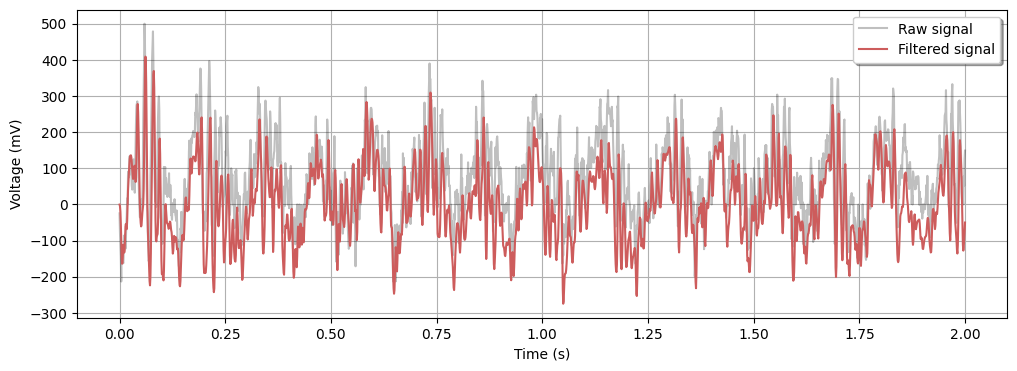

In [7]:
from scipy.signal import butter, sosfilt

# The higher the order, the sharper the filter frequency response,
# but also more computations and potential numerical instability
filter_order = 5

low_f = 1
high_f = 200

# Define filter object
filter = butter( filter_order, [low_f, high_f], btype = 'band', output = 'sos', fs = sampling_rate)
# Apply the filter to the LFP
wideband_lfp = sosfilt(filter, lfp)

plt.figure(figsize=(12,4))
plt.plot(np.linspace(0,2,2000), lfp[:2000], label = 'Raw signal', color='k', alpha = 0.25)
plt.plot(np.linspace(0,2,2000), wideband_lfp[:2000], label = 'Filtered signal', color='indianred')
plt.grid()
plt.legend(shadow = True)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')

Wideband filtering is commonly used to get rid of very low or very high frequency information. This allows us to foces on the part of the signal that we are interested in. In this case, the [1,200] Hz range is a typical one for hippocampal LFP, though it can change for different signals.

**We can also use filters to isolate particular frequency bands** that we may be interested in. For instance, we can isolate the theta band (8-12 Hz), the slow gamma (20-45 Hz) and the fast gamma (100-140 Hz) components.

For this, we'll use a function from the `lfp_functions` package.

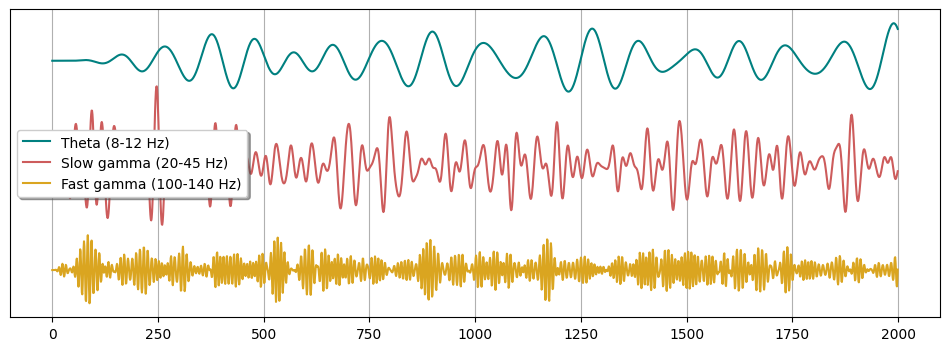

In [8]:
theta_lfp = lf.bandpass_filter(lfp, low_f = 8, high_f = 12, sampling_rate = sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp, low_f = 20, high_f = 45, sampling_rate = sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp, low_f = 100, high_f = 140, sampling_rate = sampling_rate)

plot_offset = 200

plt.figure(figsize=(12,4))
ax = plt.gca()
plt.plot(theta_lfp[:2000] + 2*plot_offset,color='teal', label='Theta (8-12 Hz)')
plt.plot(slow_gamma_lfp[:2000] + plot_offset, color='indianred', label = 'Slow gamma (20-45 Hz)')
plt.plot(fast_gamma_lfp[:2000], color='goldenrod', label = 'Fast gamma (100-140 Hz)')
plt.grid()
ax.get_yaxis().set_visible(False)
plt.legend(shadow=True)

## <font color='indianred'> TIME-FREQUENCY ANALYSIS </font>

### <font color='indianred'> Wavelets </font>

A wavelet is a *localized* oscillatory pattern. This means that, unlike the sone or cossine waves that extend indefinitely, the wavelet function $\Psi$ has finite energy $$\int_{-\infty}^{+\infty}|\Psi(x)|^2dx = E < \infty$$

This is usually achieved by constructing the wavelet function as an oscillatory function multiplied by a decaying function, typically an exponential. A popular example is the (real) Morlet wavelet which is a cosine wave multiplied by a Gaussian window $$\Psi(x, \omega) = Kcos(\omega x)e^{-x^2}$$

The parameter $\omega$ determines the carrier frequencies, that is, how many oscillations the wavelet is able to make before total dampening. Once we have our base wavelet, we can construct a whole family of them by *translating and scaling* the base function: $$\Psi_{a,b} = K_a\Psi\left( \frac{x - b}{a}\right)$$

These functions will substitute the sines and cosines and be the basis of the Morlet transform. Let's take a look at the Morlet wavelet.

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_21428\3909949723.py:4: DeprecationWarning: scipy.signal.morlet is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  wavelet = signal.morlet( 1000, s = scale, w = freq)


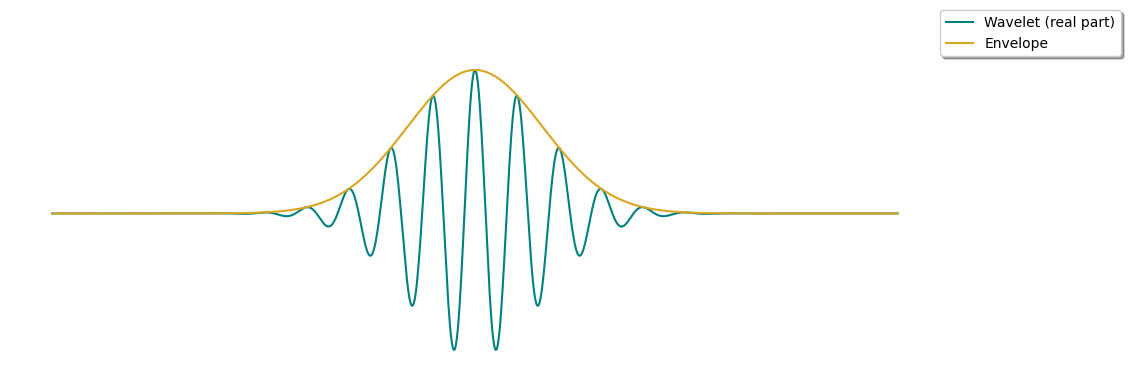

In [9]:
from scipy import signal
def plot_wavelet(scale, freq):
    
    wavelet = signal.morlet( 1000, s = scale, w = freq)
    envelope = abs(wavelet)

    plt.figure(figsize=(12,4))
    plt.plot(wavelet.real, label = 'Wavelet (real part)', color='teal')
    plt.plot(envelope, label = 'Envelope', color = 'goldenrod')
    plt.axis('off')
    plt.grid()
    plt.legend(shadow=True, loc = [1,1])
    plt.show()

# Scales = [0.05, 2] and Frequencies = [1,20]

plot_wavelet(1, 10)

### <font color='indianred'> Continuous wavelet transform </font>

The continuou swavelet transform works in a conceptually similar way to a Fourier transform, only with a different set of basis functions made by the chosen wavelet shape with different scales and frequencies. The contribution of each wavelet is computed with a convolution with the signal. Since the wavelet is a *localized* patter, it's convolution with the signal gives information about a given frequency **at a given time**. The Continuous Wavelet Transform returns a two-dimensional result, providing information in the frequency- as well as in time-domain.

As for the Fourier transform, we can use the complex part of the wavelet to take into account the phase of the signal.

<font color='darkgreen'> **A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time.**</font>

**What are the scales?**

In CWT, scales refer to the parameters that determine the width of the wavelet function and consequently the degree of localization in the time-frequency domain. Mathematically, the wavelet function is dilated or contracted by changing the scale parameter. Smaller scales result in a narrower and higher frequency wavelet, which provides better localixation in time but poorer localization in frequency. Conversely, larger scales result in a wider and lower frequency wavelet, which provides better frequency location but poorer time localization.

In practical terms, scales are typically repreented as a continuous range of values. The CWT analyses a signal across different scales, allowing the examination of its characteristics at various levels of detail.

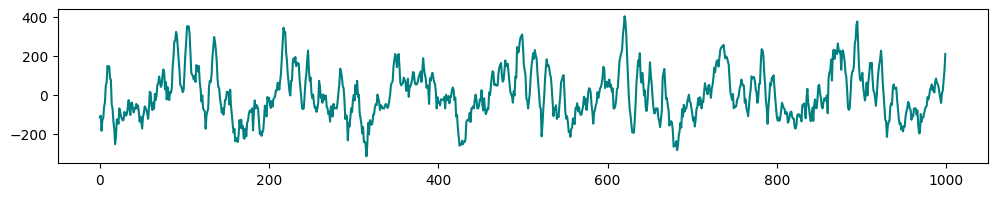

Text(0, 0.5, 'Frequencies')

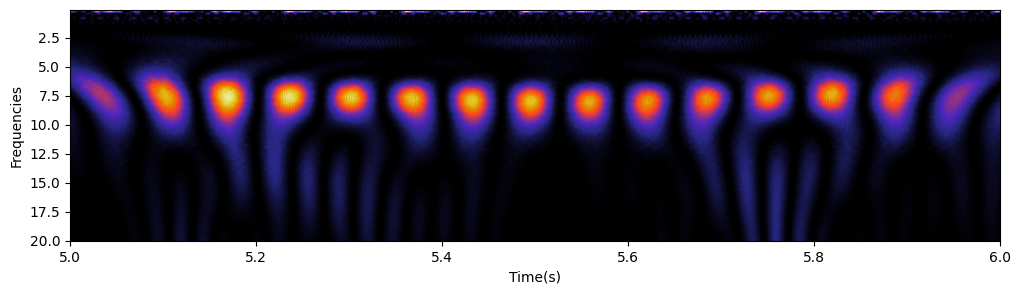

In [10]:
from pywt import scale2frequency, cwt, wavelist
start, end = 5,6 #seconds
sig = lfp[int(start * sampling_rate) : int(end * sampling_rate)]
sig -= np.mean(sig)

plt.figure(figsize=(12,2))
plt.plot(sig, color='teal')
plt.show()

# Spectrogram with Morlet transform
frequencies = np.linspace(0.1, 20, 100) / sampling_rate
wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies)

cwtmatr,_ = cwt(sig, wavelet = wavelet, scales = scales, sampling_period = 1/sampling_rate)
plt.figure(figsize=(12,3))
plt.imshow(abs(cwtmatr)**2, extent=[start, end, frequencies[-1] * sampling_rate,
                         frequencies[0] * sampling_rate], aspect='auto', cmap='CMRmap')
#plt.axis('off')
plt.xlabel('Time(s)')
plt.ylabel('Frequencies')


We can **use the wavelet transform to compute the instantaneous power in a given frequency band**. We take the spectrogram above, restrict it to the frequency band of interest and average over frequencies (along the vertical axis). This will give us the average oscilatory power in the selected frequency band at each moment in time.

Text(0, 0.5, 'Power')

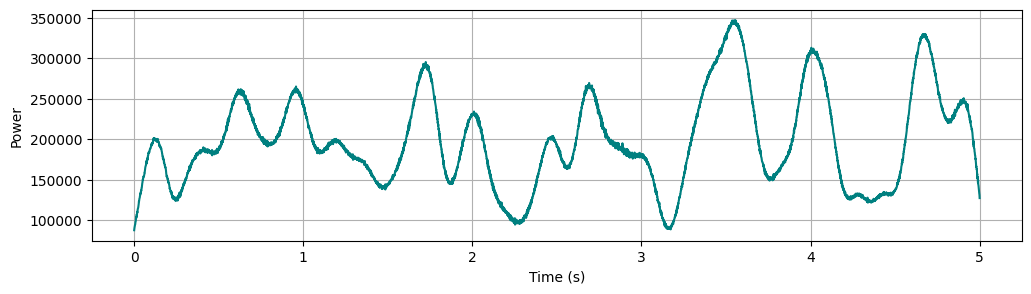

In [11]:
start, end = 0, 5
sig = lfp[int(start * sampling_rate) : int(end * sampling_rate)]
sig -= np.mean(sig)

frequencies = np.linspace(6,10,50) / sampling_rate # Hz / Hz = dimensionless
wavelet = 'cmor1.0-1.0'

scales  = scale2frequency(wavelet = wavelet, scale = frequencies)
cwtmatr, _ = cwt(data = sig, wavelet = wavelet, scales = scales)
                 #sampling_period = 1/sampling_rate)

power = np.mean(abs(cwtmatr)**2, axis = 0)

plt.figure(figsize=(12,3))
plt.plot(np.linspace(start,end, len(power)), power, color='teal')
plt.grid()
plt.xlabel('Time (s)')
plt.ylabel('Power')

### <font color='indianred'> Example: Ripple detection </font>

**Sharp wave ripples** (SWR) are a prominent oscillation pattern found in the CA1 region of the hippocampus both during sleep and awake rests. They have veen hypothesized to play an important role in the cortical consolidation of memories formed into the hippocampus. We'll use the wavelet transform to detect tipples from an LFP trace recorded in the hippocampus of a sleeping mouse.

In [12]:
with open('data/sleep_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)
sleep_lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [35]:
def compute_ripple_power(signal, sampling_rate, low_f = 100, high_f = 250):
    ''' 
    Takes the LFP signal and sampling rate
    Returns instantaneous power in the specified band.
    Default ripple band: 100-250 Hz'''
    
    signal -= np.mean(signal)
    frequencies = np.linspace(low_f, high_f, 50) / sampling_rate
    wavelet = 'cmor1.0-1.0'
    scales = scale2frequency(wavelet, frequencies)
    cwtmatr, _ = cwt(signal, wavelet = wavelet, scales = scales)
    power = np.mean(abs(cwtmatr)**2, axis = 0)
    return power

In [41]:
def ripple_idxs(ripple_mask):
    '''
    Takes logical ripple mask and return a list of arrays. Each array corresponds to a ripple
    and contains its time indx (relative to the provided ripple mask)'''
    
    ripple_starts, ripple_ends = [], []
    
    for i in range(1, len(ripple_mask)):
        if ripple_mask[i-1] == 0 and ripple_mask[i] == 1:
            ripple_starts.append(i)
        if ripple_mask[i-1] == 1 and ripple_mask[i] == 0:
            ripple_ends.append(i)
    
    if len(ripple_ends) > len(ripple_starts):
        ripple_starts = [0]+ripple_starts  # if session starts with a ripple

    if len(ripple_ends) < len(ripple_starts):
        ripple_ends.append(len(ripple_mask))  # if session ends with a ripple

    ripples = [np.arange(ripple_starts[i], ripple_ends[i])
               for i in range(len(ripple_starts))]

    return ripples

def clean_ripples(ripples, lfp, ripple_len_threshold = None, amplitude_threshold = None):
    '''
    Takes list of ripples and corresponding signal,
    Returns list of ripples cleaned of ripples that are shorther than specified
    duration threshold or with amplitude larger than specified threshold'''

    clean_ripples = [r for r in ripples if (len(r) > ripple_len_threshold and max(lfp[r]) < amplitude_threshold and min(lfp[r]) > - amplitude_threshold)]
    return clean_ripples

The `zscore` (aka, standard score) is $z = \frac{x - \mu}{\sigma}$.

To find the ripples, we follow these steps:

1. Measure the LFP signal.
2. Extract the LFP signal power spectrum.
3. Standardize the power spectrum using z-score.
4. Find the ripples using a ripple mask to find the time indices of where each starts and finishes.
5. Clean the ripples using amplitude and length thresholds.
6. Apply band pass filter with default ripple band frequency.
7. Use the `clean_ripple` indices to plot each ripple.

In [45]:
from scipy.stats import zscore
ripple_th = 2 # Ripple threshold!!
ripple_power = compute_ripple_power(sleep_lfp, sampling_rate)

In [46]:
zscored_power = zscore(ripple_power)
ripple_mask = np.asarray([True if x > ripple_th else 0 for x in zscored_power])
ripples = ripple_idxs(ripple_mask)
ripples = clean_ripples(ripples, sleep_lfp, ripple_len_threshold = 30, amplitude_threshold = 1000)
print(f'Detected {len(ripples)} ripples')

Detected 23 ripples


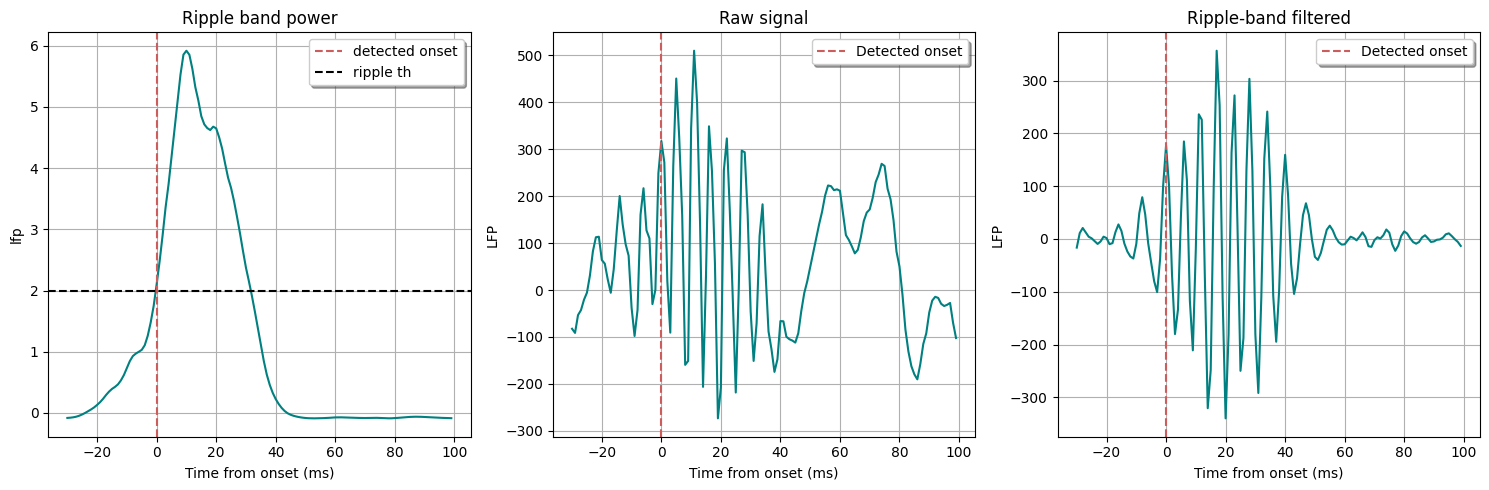

In [27]:
ripple_n = 1
ripple_lfp = lf.bandpass_filter(sleep_lfp, low_f = 100, high_f=250, sampling_rate = sampling_rate)

plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = zscored_power[onset-30:onset+100]
plt.plot(x,y, color='teal')
plt.axvline(x = 0,linestyle='--', c='indianred',label = 'detected onset')
plt.axhline(y = 2,linestyle='--', c='k',label = 'ripple th')

plt.title('Ripple band power')
plt.xlabel('Time from onset (ms)')
plt.ylabel('lfp')
plt.legend(shadow=True)
plt.grid()

plt.subplot(1,3,2)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = sleep_lfp[onset-30:onset+100]
plt.plot(x,y, color='teal')
plt.axvline(x=0,linestyle='--',c='indianred',label='Detected onset')
plt.title('Raw signal')
plt.xlabel('Time from onset (ms)')
plt.ylabel('LFP')
plt.legend(shadow=True)
plt.grid()

plt.subplot(1,3,3)
onset = ripples[ripple_n][0]
x = np.arange(-30,100)
y = ripple_lfp[onset-30:onset+100]
plt.plot(x,y, color='teal')
plt.axvline(x=0,linestyle='--', c='indianred',label='Detected onset')
plt.title('Ripple-band filtered')
plt.xlabel('Time from onset (ms)')
plt.ylabel('LFP')
plt.legend(shadow=True)
plt.grid()

plt.tight_layout()

# KEY POINTS

- The Fourier transform of the LFP signal gives information about its frequency content on average in a given observation window.
- Filtering can be used to isolate and inspect the signal in certain frequency bands as well as eliminating the high or low frequency components when they get in the way.
- Time-frequency analysis with CWT (continuous wavelet transforms) can give insights about the local, time instant by time instant frequency content.
- There is a fundamental tradeoff between the time ad frequency resolutions due to the uncertainty principle.